In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('../data/drinking_water_potability.csv')

# Data cleaning

In [8]:
# Imputación
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Inicializar el imputador iterativo
imputer = IterativeImputer()

# Entrenar el imputador en los datos con valores faltantes
imputer.fit(df)

# Transformar los datos para imputar los valores faltantes
df_imputed = pd.DataFrame(imputer.transform(df), columns=df.columns)

# Verificar que no hay valores faltantes después de la imputación
print("Valores faltantes después de la imputación:")
print(df_imputed.isnull().sum())

# Outliers

from sklearn.ensemble import IsolationForest

# Seleccionar solo las columnas numéricas
numeric_columns = df_imputed.select_dtypes(include=['float64', 'int64'])

# Inicializar y ajustar el modelo Isolation Forest
clf = IsolationForest(random_state=0)
clf.fit(numeric_columns)

# Identificar los valores atípicos (1 para valores normales, -1 para valores atípicos)
outliers = clf.predict(numeric_columns)

# Filtrar solo los valores normales (no atípicos)
df_cleaned = df_imputed[outliers == 1]

# Normalizacion

from sklearn.preprocessing import MinMaxScaler

# Seleccionar las características numéricas
numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64'])

scaler = MinMaxScaler()

numeric_columns_scaled = scaler.fit_transform(numeric_columns)

df_scaled = pd.DataFrame(numeric_columns_scaled, columns=numeric_columns.columns)

# Balanceo de datos
from imblearn.over_sampling import RandomOverSampler

# Seleccionar tus características y la variable objetivo
X = df_scaled.drop('Potability', axis=1)  # Asegúrate de cambiar 'target_variable' por el nombre de tu variable objetivo
y = df_scaled['Potability']

# Inicializar el objeto RandomOverSampler
oversampler = RandomOverSampler(random_state=0)

# Aplicar el sobremuestreo a tus datos
X_resampled, y_resampled = oversampler.fit_resample(X, y)

Valores faltantes después de la imputación:
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


# Divicion de datos

In [9]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Seleccion de datos importantes

           feature  importance       std
0               ph    0.127395  0.018392
1         Hardness    0.122393  0.017325
4          Sulfate    0.115309  0.016348
3      Chloramines    0.114821  0.017601
2           Solids    0.114441  0.016521
6   Organic_carbon    0.105554  0.016581
5     Conductivity    0.102732  0.016001
8        Turbidity    0.099132  0.016055
7  Trihalomethanes    0.098223  0.016080


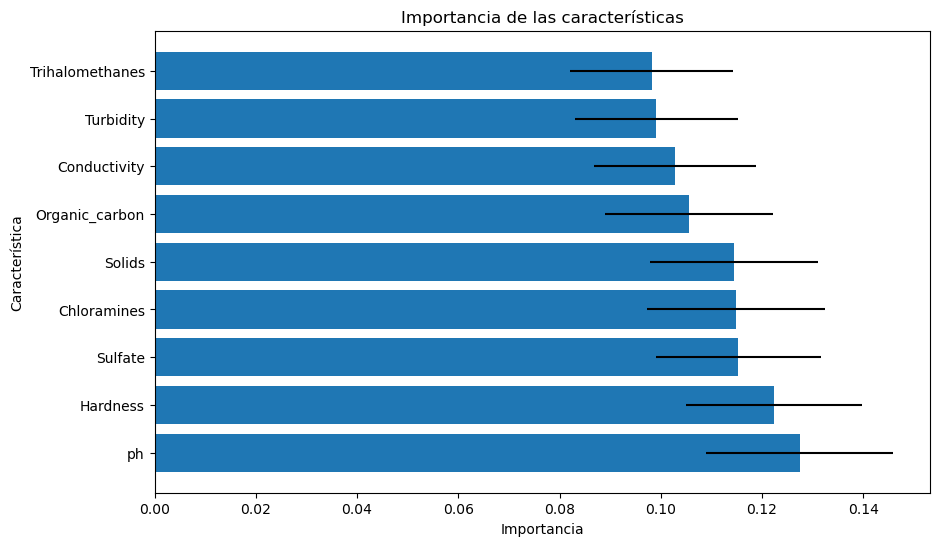

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, random_state=2)
rf.fit(X_train, y_train)

# Obtener la importancia de las características
importances = rf.feature_importances_

# Obtener la desviación estándar de las importancias de las características
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Crear un DataFrame con las características y sus importancias
df_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})

# Ordenar el DataFrame por importancia
df_importances = df_importances.sort_values('importance', ascending=False)

print(df_importances)
plt.figure(figsize=(10, 6))
plt.barh(df_importances['feature'], df_importances['importance'], xerr=df_importances['std'], align='center')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características')
plt.show()

select_features=df_importances[df_importances.importance>=0.05].feature

# Modelo

In [11]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [12]:
model = xgb.XGBClassifier()

# Define los hiperparámetros que deseas ajustar
param_grid = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
    'reg_lambda': [0, 0.01, 0.1, 1, 10]
}


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

In [13]:
grid_search.fit(X_train, y_train)

In [ ]:
# Obtiene los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtiene el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Evalúa el modelo en los datos de prueba
mse = mean_squared_error(y_test, best_model.predict(X_test))
print("Error cuadrático medio en datos de prueba:", mse)